In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.mllib.tree import GradientBoostedTrees, GradientBoostedTreesModel
from sklearn.model_selection import train_test_split
from pyspark.sql.functions import *
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_recall_curve, auc
import time
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
spark=SparkSession.builder.appName('Australian_rain_prediction').getOrCreate()
sc = spark.sparkContext

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/09 12:04:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


**Read dataset from HDFS**

In [3]:
df=spark.read.csv('hdfs://localhost:9000/user/bigdata2022/datasets/Australia1.csv',inferSchema=True,header=True)


In [4]:
print(df.columns)

['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Cloud9am', 'Cloud3pm', 'RainToday', 'RainTomorrow', 'Month', 'Location_Albany', 'Location_Albury', 'Location_AliceSprings', 'Location_BadgerysCreek', 'Location_Ballarat', 'Location_Bendigo', 'Location_Brisbane', 'Location_Cairns', 'Location_Canberra', 'Location_Cobar', 'Location_CoffsHarbour', 'Location_Dartmoor', 'Location_Darwin', 'Location_GoldCoast', 'Location_Hobart', 'Location_Katherine', 'Location_Launceston', 'Location_Melbourne', 'Location_MelbourneAirport', 'Location_Mildura', 'Location_Moree', 'Location_MountGambier', 'Location_MountGinini', 'Location_Newcastle', 'Location_Nhil', 'Location_NorahHead', 'Location_NorfolkIsland', 'Location_Nuriootpa', 'Location_PearceRAAF', 'Location_Penrith', 'Location_Perth', 'Location_PerthAirport', 'Location_Portland', 'Location_Richmond', 'Location_Sale', 'Location_SalmonGums', 'Locati

In [5]:
print(df.head())

22/12/09 12:04:19 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
Row(MinTemp=13.4, MaxTemp=22.9, Rainfall=0.6, Evaporation=5.472515506887167, Sunshine=8.5, WindGustSpeed=44.0, WindSpeed9am=20.0, WindSpeed3pm=24.0, Humidity9am=71.0, Humidity3pm=22.0, Pressure9am=1007.7, Cloud9am=8.0, Cloud3pm=5.0, RainToday=0.0, RainTomorrow=0.0, Month=12, Location_Albany=0, Location_Albury=1, Location_AliceSprings=0, Location_BadgerysCreek=0, Location_Ballarat=0, Location_Bendigo=0, Location_Brisbane=0, Location_Cairns=0, Location_Canberra=0, Location_Cobar=0, Location_CoffsHarbour=0, Location_Dartmoor=0, Location_Darwin=0, Location_GoldCoast=0, Location_Hobart=0, Location_Katherine=0, Location_Launceston=0, Location_Melbourne=0, Location_MelbourneAirport=0, Location_Mildura=0, Location_Moree=0, Location_MountGambier=0, Location_MountGinini=0, Location_Newcastle=0, Location_Nhil=0, Locatio

In [6]:
start_time=time.time()

**Pipeline**

In [7]:
df_1 = df.drop('RainTomorrow')

In [8]:
assembler = VectorAssembler(inputCols=df_1.columns, outputCol="features_to_scale")

In [9]:
scaler = MinMaxScaler(inputCol="features_to_scale", outputCol="features_scaled")

In [10]:
model = GBTClassifier(labelCol="RainTomorrow", featuresCol="features_scaled", maxIter=10)

In [11]:
pipeline = Pipeline(stages=[assembler, scaler, model])

**Split the dataset**

In [12]:
training_data, test_data = df.randomSplit([0.75, 0.25])

**Training**

In [13]:
pipeline_model = pipeline.fit(training_data)

**Test**

In [14]:
predictions = pipeline_model.transform(test_data)

In [15]:
predictions.select("prediction", "RainTomorrow").show(100)

22/12/09 12:04:47 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/12/09 12:04:47 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
+----------+------------+
|prediction|RainTomorrow|
+----------+------------+
|       0.0|         0.0|
|       0.0|         0.0|
|       0.0|         0.0|
|       0.0|         0.0|
|       0.0|         0.0|
|       0.0|         1.0|
|       0.0|         0.0|
|       0.0|         0.0|
|       0.0|         0.0|
|       0.0|         0.0|
|       0.0|         0.0|
|       0.0|         0.0|
|       0.0|         0.0|
|       0.0|         0.0|
|       0.0|         0.0|
|       0.0|         0.0|
|       0.0|         0.0|
|       0.0|         0.0|
|       0.0|         0.0|
|       0.0|         0.0|
|       0.0|         0.0|
|       0.0|         0.0|
|       0.0|         0.0|
|       0.0|         0.0|
|       0.0|         0.0|
|       0.0|         0.0|


**Model evaluation**

In [16]:
t_test=predictions.select('RainTomorrow').toPandas()
t_hat=predictions.select('prediction').toPandas()

In [17]:
print("\nAccuracy score on the test set: ", accuracy_score(t_test, t_hat))


Accuracy score on the test set:  0.8447210275981886


In [18]:
print("\nF1-score score on the test set: ", f1_score(t_test, t_hat))


F1-score score on the test set:  0.5606768734891217


In [19]:
print('Test-set accuracy score: {0:0.4f}'. format(accuracy_score(t_test, t_hat)))
print(classification_report(t_test,t_hat))

Test-set accuracy score: 0.8447
              precision    recall  f1-score   support

         0.0       0.86      0.96      0.91     27392
         1.0       0.74      0.45      0.56      7719

    accuracy                           0.84     35111
   macro avg       0.80      0.70      0.73     35111
weighted avg       0.83      0.84      0.83     35111



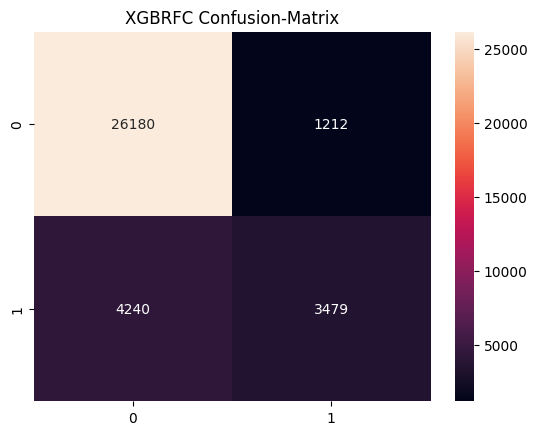

In [20]:
ax = plt.axes()
cm = confusion_matrix(t_test, t_hat)
sns.heatmap(cm, annot=True, fmt='d', ax=ax)
ax.set_title('XGBRFC Confusion-Matrix')
plt.show()

In [21]:
print(time.time()-start_time)

33.935643672943115
